## 호텔 예약 취소자 예측

### 목표 : 호텔 예약 취소 여부 예측

### 데이터 설명

**target : is_canceled : 정상 - 0, 예약 취소 - 1**

hotel : 호텔의 종류

lead_time : 예약을 입력한 날짜와 도착 날짜 사이에 경과된 일 수

arrival_date_year : 도착 연도

arrival_date_month : 도착 월

arrival_date_week_number : 도착 주

arrival_date_day_of_month : 도착 일

stays_in_weekend_nights : 주말 숙박 예약 횟수

stays_in_week_nights : 주중 숙박 예약 횟수

adults : 성인

children : 아이들

babies : 애기

meal : 식사 타입

country : 국가

distribution_channel : 유통 채널

is_repeated_guest : 단골 손님

previous_cancellations : 예약 전에 고객이 취소한 이전 예약 수

previous_bookings_not_canceled : 예약 전에 고객이 취소하지 않은 이전 예약 수

reserved_room_type : 예약된 객실 유형 

booking_changes : 예약을 변경한 횟수

deposit_type : 위약금

days_in_waiting_list : 예약이 고객에게 확인되기 전에 대기 목록에 있었던 일 수

customer_type : 고객 타입

adr : 객실 평균 요금

required_car_parking_spaces : 주차 공간

total_of_special_requests : 특별한 요청

reservation_status : 예약 상태

reservation_status_date : 예약 상태 날짜

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
import shap
from scipy.stats import randint, uniform
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.impute import SimpleImputer
from pdpbox.pdp import pdp_isolate, pdp_plot

%matplotlib inline
warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False


In [2]:
# 데이터 불러오기
df = pd.read_csv('/Users/mingi.kim/Desktop/자료/kaggle/Hotel Booking/hotel_bookings.csv')

# target data
target = 'is_canceled'

In [3]:
# 데이터 확인
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# 데이터 갯수
df.shape

(119390, 32)

In [5]:
# 데이터 타입 확인
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [6]:
# 숫자형 데이터 확인
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [7]:
# 결측치 확인
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
# 중복값 확인
df[df.duplicated()]

# 중복값 제거
df.drop_duplicates(keep = 'first', inplace = True)

### Feature EDA 진행

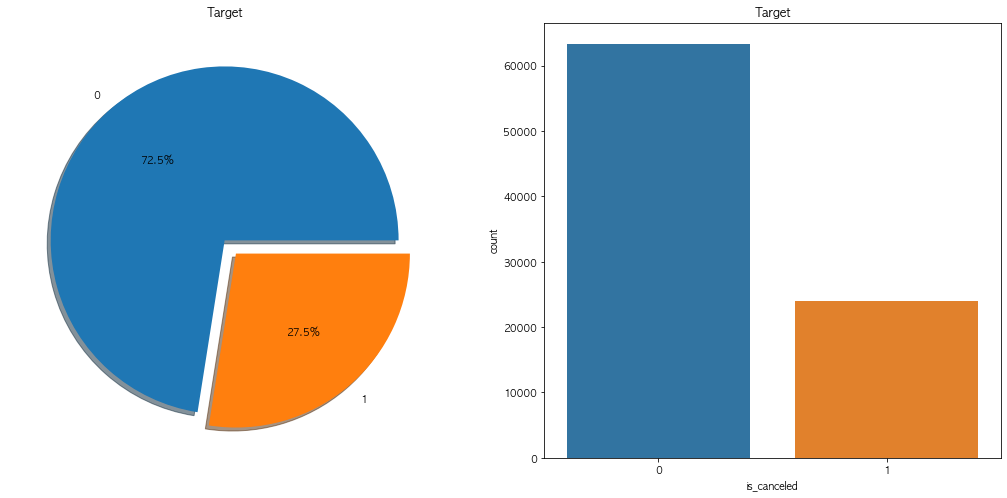

In [9]:
# Target label 확인
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

df[target].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', shadow = True, ax = ax[0])
ax[0].set(title = 'Target', ylabel = '')

sns.countplot(df[target], ax = ax[1])
ax[1].set(title = 'Target')
plt.show()

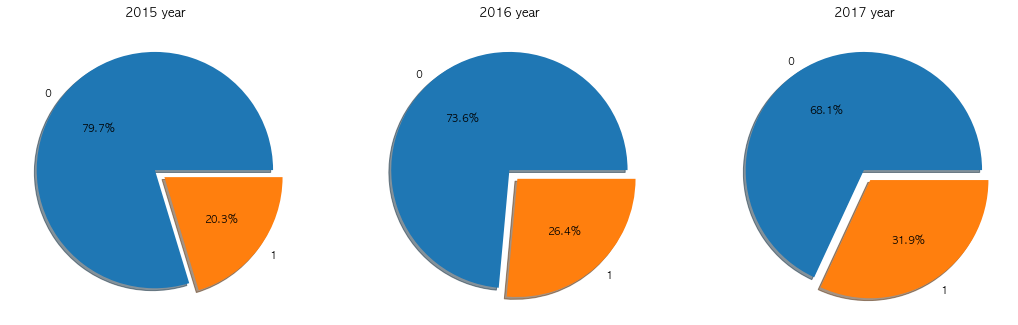

In [10]:
# Target label 확인
fig, ax = plt.subplots(1, 3, figsize = (18, 8))


df[df['arrival_date_year'] == 2015][target].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', shadow = True, ax = ax[0])
ax[0].set(title = '2015 year', ylabel = '')

df[df['arrival_date_year'] == 2016][target].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', shadow = True, ax = ax[1])
ax[1].set(title = '2016 year', ylabel = '')

df[df['arrival_date_year'] == 2017][target].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', shadow = True, ax = ax[2])
ax[2].set(title = '2017 year', ylabel = '')

plt.show()

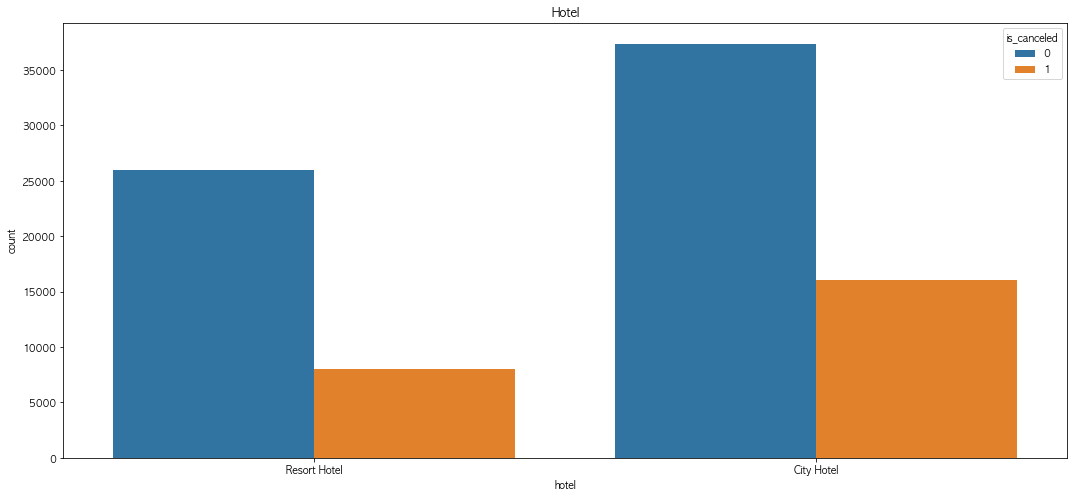

In [11]:
# hotel 종류 확인
fig, ax = plt.subplots(1, 1, figsize = (18, 8))
sns.countplot(df['hotel'], hue = df[target])
ax.set(title = 'Hotel')
plt.show()

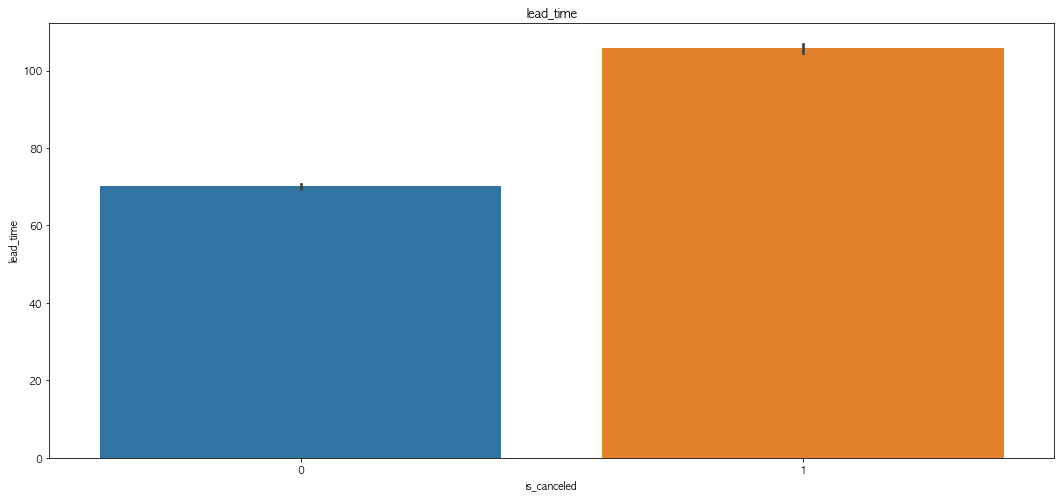

In [12]:
# 예약 시간에 따른 취소 확인
fig, ax = plt.subplots(1, 1, figsize = (18, 8))

sns.barplot(x = target, y = 'lead_time', data = df)
ax.set(title = 'lead_time')

plt.show()

<AxesSubplot:xlabel='arrival_date_year', ylabel='count'>

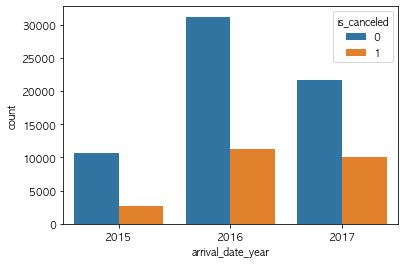

In [13]:
# 연도별 취소율
sns.countplot(df['arrival_date_year'], hue = df['is_canceled'])

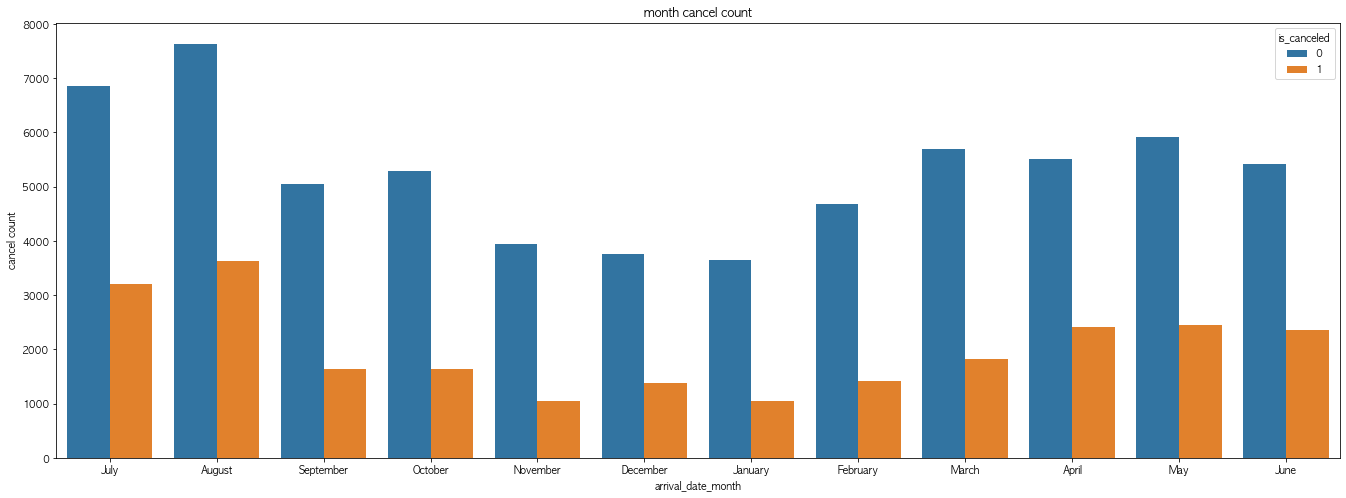

In [14]:
# 월별 취소율
fig, ax = plt.subplots(1, 1, figsize = (23, 8))

sns.countplot(x = 'arrival_date_month', hue = 'is_canceled', data = df)
ax.set(title = 'month cancel count', ylabel = 'cancel count')
plt.show()

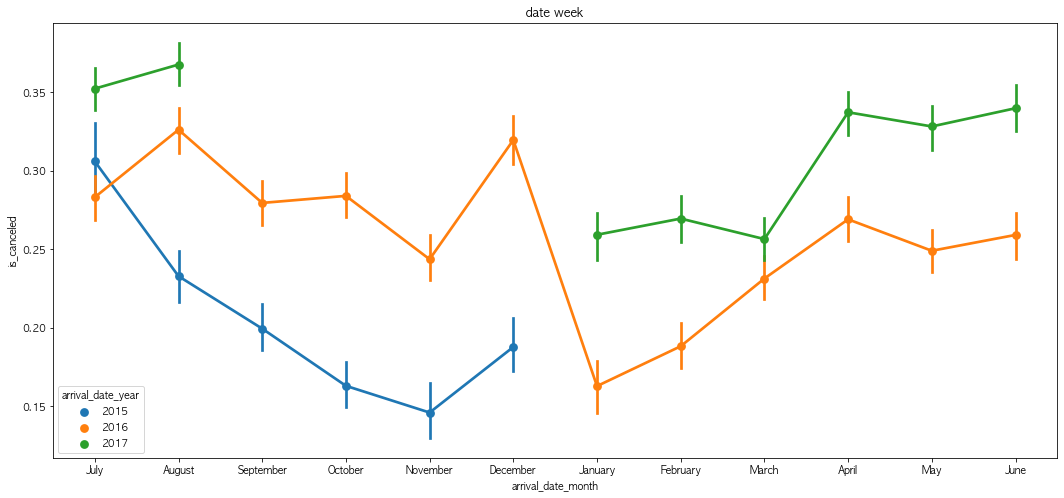

In [15]:
# 날짜로 확인하기
fig, ax = plt.subplots(1, 1, figsize = (18, 8))

sns.pointplot(x = 'arrival_date_month', y = 'is_canceled', hue = 'arrival_date_year', data = df, ax = ax)
ax.set(title = 'date week')

plt.show()

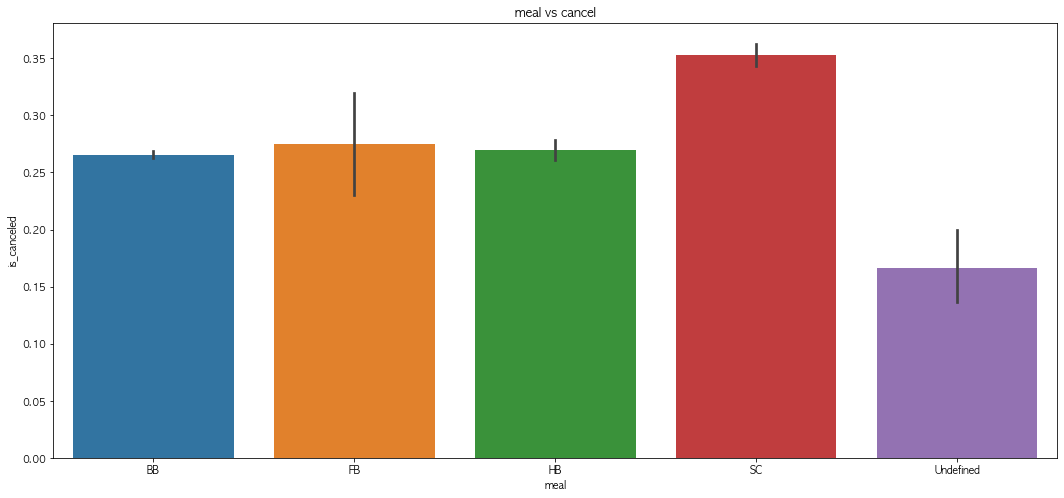

In [16]:
# 식사 유형별 취소율
fig, ax = plt.subplots(1, 1, figsize = (18, 8))

sns.barplot(x = 'meal', y = 'is_canceled', data = df)
ax.set(title = 'meal vs cancel')
plt.show()

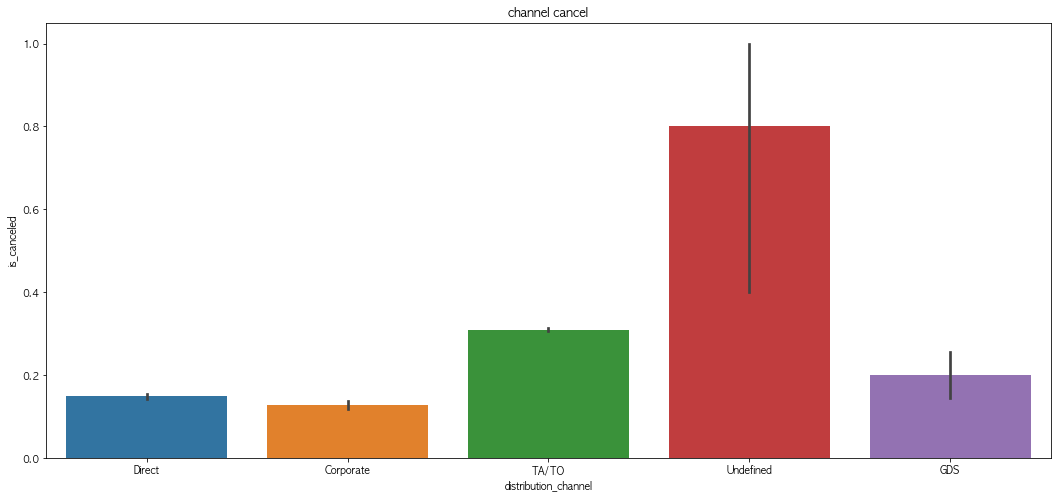

In [17]:
# 예약 채널별 취소율
fig, ax = plt.subplots(1, 1, figsize = (18, 8))

sns.barplot(x = 'distribution_channel', y = 'is_canceled', data = df)
ax.set(title = 'channel cancel')
plt.show()

In [18]:
# Undefined 값으로 최빈값으로 대처 예정
df.distribution_channel.value_counts()

TA/TO        69141
Direct       12988
Corporate     5081
GDS            181
Undefined        5
Name: distribution_channel, dtype: int64

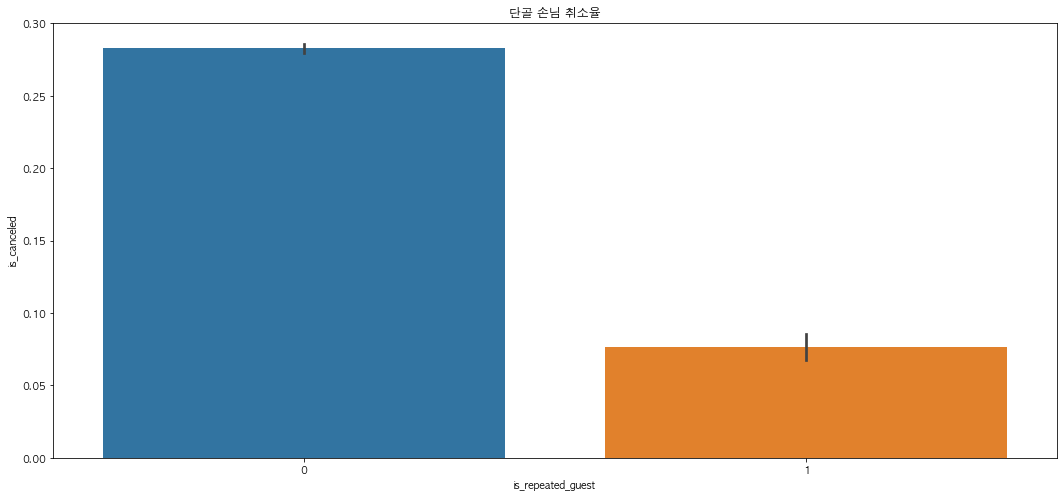

In [19]:
# 단골 손님 확인
fig, ax = plt.subplots(1, 1, figsize = (18, 8))

sns.barplot(x = 'is_repeated_guest', y = 'is_canceled', data = df)
ax.set(title = '단골 손님 취소율')

plt.show()

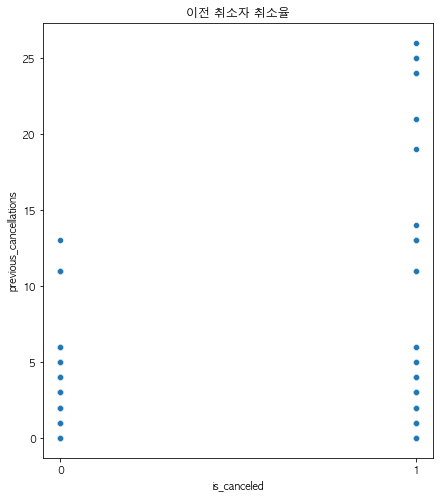

In [21]:
# previous_cancellations : 예약 전에 고객이 취소한 이전 예약 수
df.previous_cancellations.value_counts()

fig, ax = plt.subplots(1, 1, figsize = (7, 8))
sns.scatterplot(x = 'is_canceled', y = 'previous_cancellations', data = df)
ax.set(title = '이전 취소자 취소율', xticks = (range(0, 2, 1)))
plt.show()

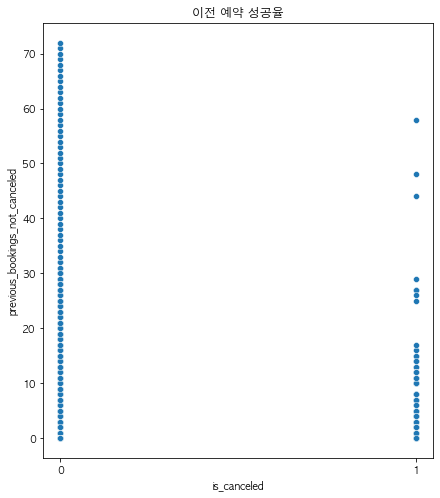

In [22]:
# previous_bookings_not_canceled : 예약 전에 고객이 취소하지 않은 이전 예약 수
df.previous_bookings_not_canceled.value_counts()

fig, ax = plt.subplots(1, 1, figsize = (7, 8))
sns.scatterplot(x = 'is_canceled', y = 'previous_bookings_not_canceled', data = df)
ax.set(title = '이전 예약 성공율', xticks = (range(0, 2, 1)))
plt.show()

In [23]:
# 예약 변경 횟수 확인
pd.crosstab(df.is_canceled, df.booking_changes, margins = True).style.background_gradient(cmap = 'summer_r')

booking_changes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,All
is_canceled,,,,,,,,,,,,,,,,,,,,,,
0,49926,9391,2804,744,293,96,42,28,13,7,5,2,2,5,4,3,1,2,1,1,1,63371
1,21568,1511,704,131,63,20,17,3,4,1,1,0,0,0,1,0,1,0,0,0,0,24025
All,71494,10902,3508,875,356,116,59,31,17,8,6,2,2,5,5,3,2,2,1,1,1,87396


<AxesSubplot:xlabel='deposit_type', ylabel='is_canceled'>

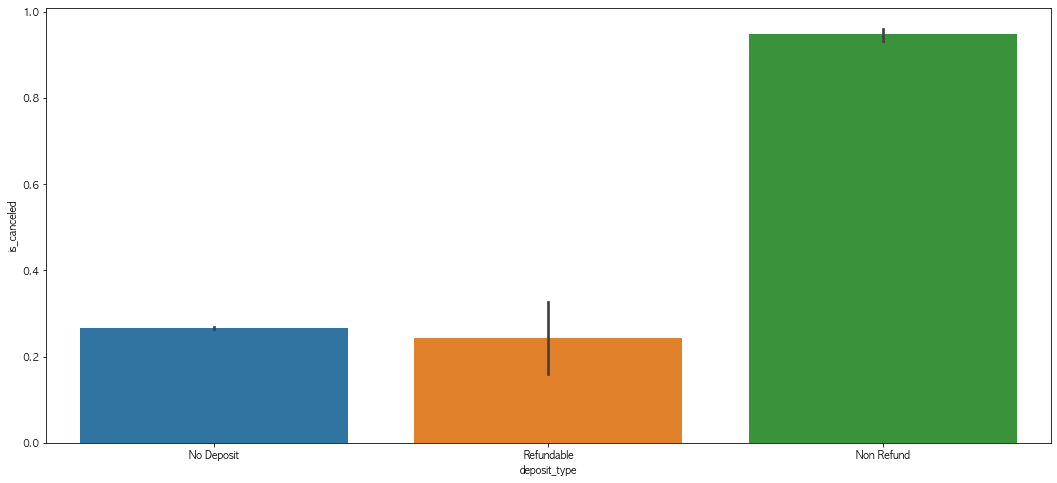

In [24]:
# 위약금 여부 
fig, ax = plt.subplots(1, 1, figsize = (18, 8))
sns.barplot(x = 'deposit_type', y = 'is_canceled', data = df)


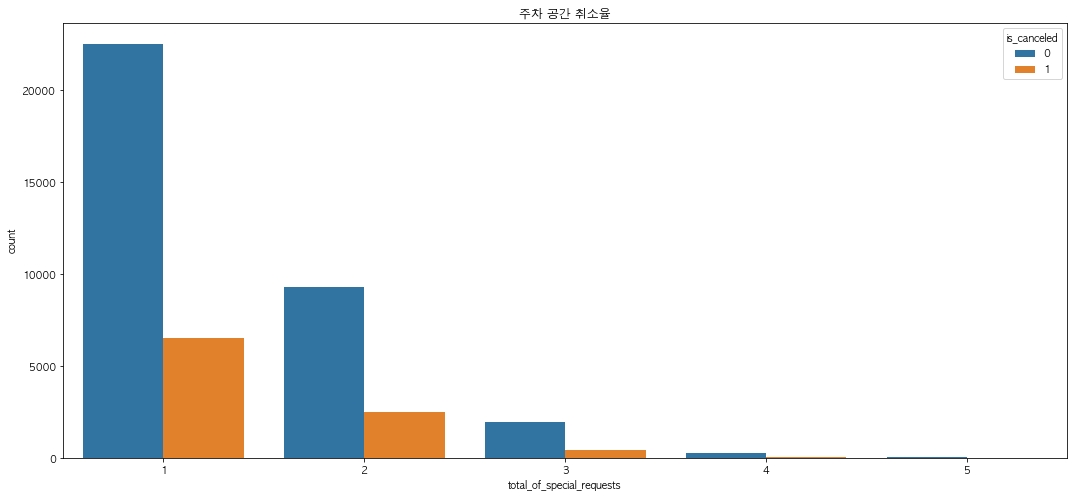

In [26]:
# required_car_parking_spaces : 총 주차 공간
a = df[df['total_of_special_requests'] >= 1]

fig, ax = plt.subplots(1, 1, figsize = (18, 8))
sns.countplot(x = 'total_of_special_requests', hue = 'is_canceled', data = a)
ax.set(title = '주차 공간 취소율')
plt.show()

### Data Engineering 

삭제 컬럼
arrival_date_week_number

arrival_date_day_of_month

reservation_status

reservation_status_date

agent

company

market_segment

In [27]:
# 데이터셋 나누기
train, test = train_test_split(df, train_size = 0.8, test_size = 0.2, stratify = df[target])
train, val = train_test_split(train, train_size = 0.8, test_size = 0.2, stratify = train[target])

train.shape, val.shape, test.shape

((55932, 32), (13984, 32), (17480, 32))

In [28]:
def engineering(df):
    
    # 결측치 처리
    df['children'].fillna(0, inplace = True)
    
    # Undefind 최빈값 변경
    df.loc[df['distribution_channel'] == 'Undefined', 'distribution_channel'] = df.distribution_channel.mode()[0]
    
    # 예약 변경 횟수 변경 이력이 있으면 1, 없으면 0
    df['changes'] = 0
    df.loc[df['booking_changes'] > 0, 'changes'] = 1
    

    # adr 
    # 숙박 요금이 0원 삭제
    cash = (df['adr'] <= 0)
    df = df.loc[~cash]
    
    
    df.loc[df['adr'] <= 100, 'adr'] = 1
    df.loc[(df['adr'] > 100) & (df['adr'] <= 200), 'adr'] = 2
    df.loc[(df['adr'] > 200) & (df['adr'] <= 300), 'adr'] = 3
    df.loc[(df['adr'] > 300) & (df['adr'] <= 400), 'adr'] = 4
    df.loc[(df['adr'] > 400) & (df['adr'] <= 500), 'adr'] = 5
    df.loc[df['adr'] > 500, 'adr'] = 6

    # lead_time
    df.loc[df['lead_time'] <= 100, 'lead_time'] = 1
    df.loc[(df['lead_time'] > 100) & (df['lead_time'] <= 200), 'lead_time'] = 2
    df.loc[(df['lead_time'] > 200) & (df['lead_time'] <= 300), 'lead_time'] = 3
    df.loc[(df['lead_time'] > 300) & (df['lead_time'] <= 400), 'lead_time'] = 4
    df.loc[(df['lead_time'] > 400) & (df['lead_time'] <= 500), 'lead_time'] = 5
    df.loc[(df['lead_time'] > 500) & (df['lead_time'] <= 600), 'lead_time'] = 6
    df.loc[df['lead_time'] > 600, 'lead_time'] = 7
    
    # total stays
    df['total_stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    
    # 이전 취소자들
    df['cancel'] = 0
    df.loc[df['previous_cancellations'] > 0, 'cancel'] = 1
    
    # feature 제거
    df.drop(columns = ['required_car_parking_spaces', 'stays_in_weekend_nights', 'stays_in_week_nights', 'market_segment', 'company', 'assigned_room_type', 'total_of_special_requests', 'arrival_date_day_of_month', 'reservation_status', 'reservation_status_date'], inplace = True)
    
    #결측치 제거
    df = df.loc[~df['country'].isnull()]
    
    # 결측치 처리
    df.loc[df['agent'].isnull(), 'agent'] = 0
    
    return df

df = engineering(df)
train = engineering(train)
test = engineering(test)
val = engineering(val)

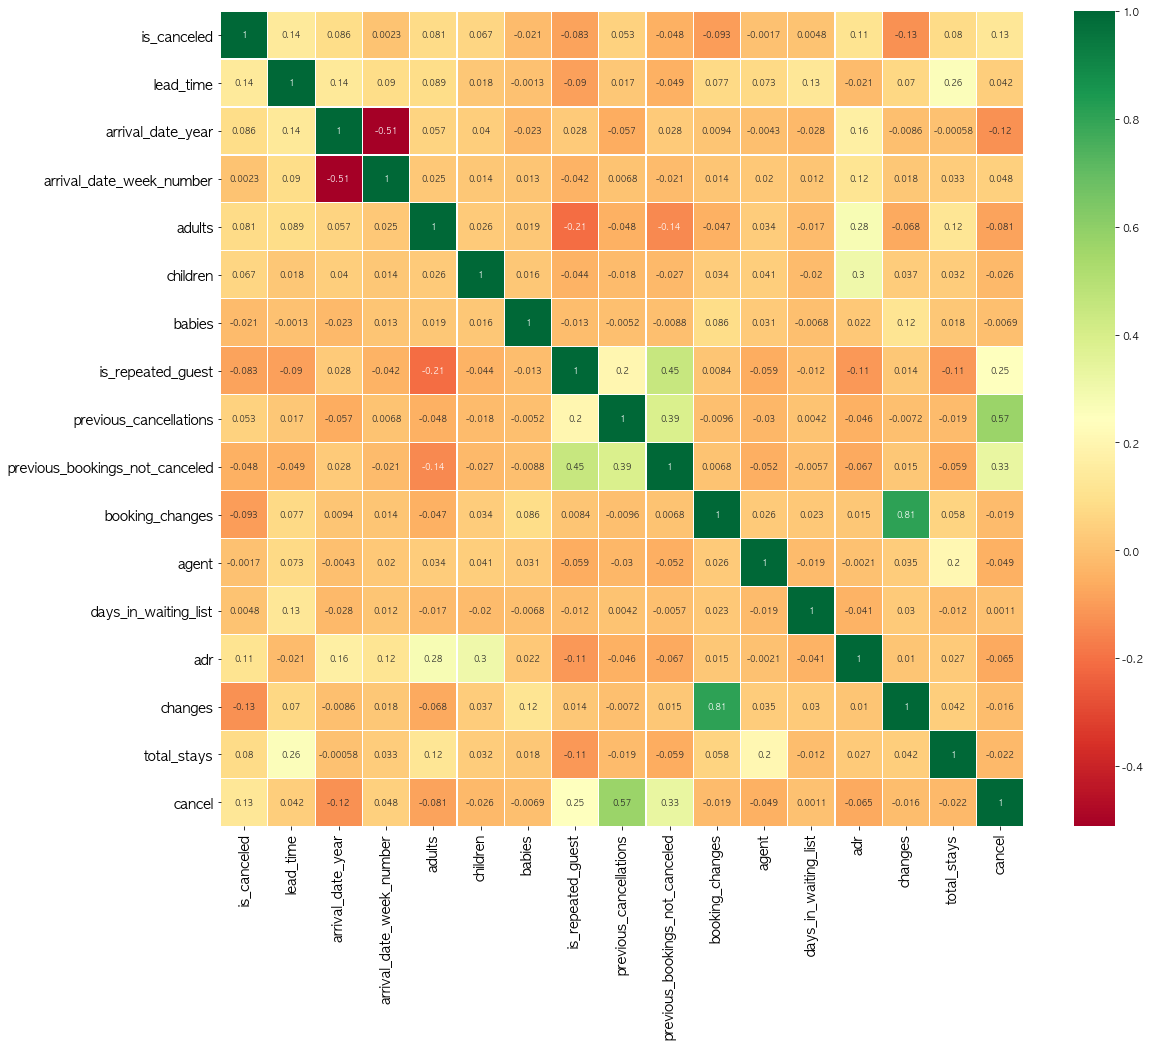

In [29]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':8})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [30]:
# 타겟 데이터 분리
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

In [31]:
# 기준 모델 
major = y_train.mode()[0]
baseline = [major] * len(y_val)
print('기준 모델 Score : ', accuracy_score(y_val, baseline))

기준 모델 Score :  0.7198618053513672


In [32]:
# RandomForest Model
pipe_RF = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
)

pipe_RF.fit(X_train, y_train)
y_pred = pipe_RF.predict(X_val)
print('Accuracy score : ', accuracy_score(y_val, y_pred))

Accuracy score :  0.7825639517788886


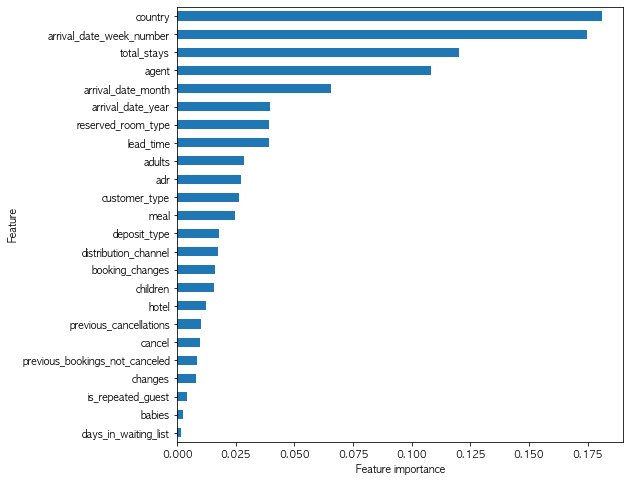

In [33]:
rf = pipe_RF.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

plt.figure(figsize=(8, 8))
importances.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [34]:
# XGBoost
pipe_XG = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)

pipe_XG.fit(X_train, y_train)
y_pred = pipe_XG.predict(X_val)
print('Accuracy score : ', accuracy_score(y_val, y_pred))

[16:26:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score :  0.7938841517200823


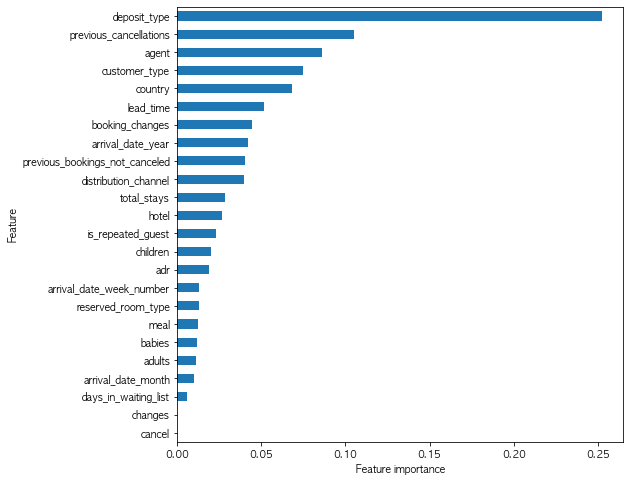

In [35]:
xg = pipe_XG.named_steps['xgbclassifier']
importances = pd.Series(xg.feature_importances_, X_train.columns)

plt.figure(figsize=(8, 8))
importances.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [36]:
# XGBoost
dictx = {
    'xgbclassifier__n_estimators' : randint(100, 500),
    'xgbclassifier__max_depth' : [9, 11, 15, 18, None],
    'xgbclassifier__learning_rate ' : [0.1, 0.09, 0.07],
}

clf_XG = RandomizedSearchCV(
    pipe_XG,
    param_distributions = dictx,
    n_iter = 20,
    cv = 2,
    scoring = 'accuracy',
    n_jobs = -1
)
clf_XG.fit(X_train, y_train)

[16:32:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { learning_rate  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['hotel',
                                                                   'arrival_date_month',
                                                                   'meal',
                                                                   'country',
                                                                   'distribution_channel',
                                                                   'reserved_room_type',
                                                                   'deposit_type',
                                                                   'customer_type'],
                                                             mapping=[{'col': 'hotel',
                                                                       'data_type': dtype('O'),
                                                              

In [37]:
print(clf_XG.best_score_)
print(clf_XG.best_params_)

0.790475142982842
{'xgbclassifier__learning_rate ': 0.1, 'xgbclassifier__max_depth': None, 'xgbclassifier__n_estimators': 263}


In [76]:
encoder = OrdinalEncoder()
X_train_en = encoder.fit_transform(X_train)
X_val_en = encoder.transform(X_val)
X_test_en = encoder.transform(X_test)

In [77]:
XG_model = XGBClassifier(learning_rate = 0.07, n_estimators = 110)
XG_model.fit(X_train_en, y_train)

[16:52:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=110, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
y_pred = XG_model.predict(X_test_en)
y_pred_pro = XG_model.predict_proba(X_test_en)

y_pred_ba = (y_pred_pro[:, 1] >= 0.62).astype('int')
print('accuracy Score : ', round(accuracy_score(y_test, y_pred_ba) * 100),'%')
print('precision Score : ', round(precision_score(y_test, y_pred_ba) * 100), '%')

accuracy Score :  77 %
precision Score :  83 %


In [79]:
eli5.show_weights(
    XG_model,
    top = None,
    feature_names = X_test.columns.tolist()
)

Weight,Feature
0.1546,deposit_type
0.1125,agent
0.1099,country
0.0846,customer_type
0.0728,lead_time
0.0720,previous_cancellations
0.0567,booking_changes
0.0442,arrival_date_year
0.0420,total_stays
0.0417,distribution_channel


In [84]:
top = ['deposit_type', 'agent', 'country']

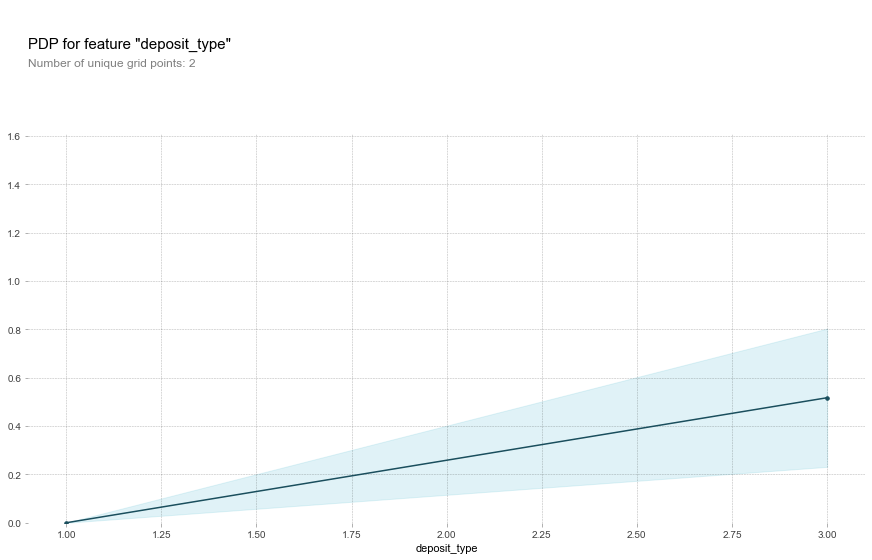

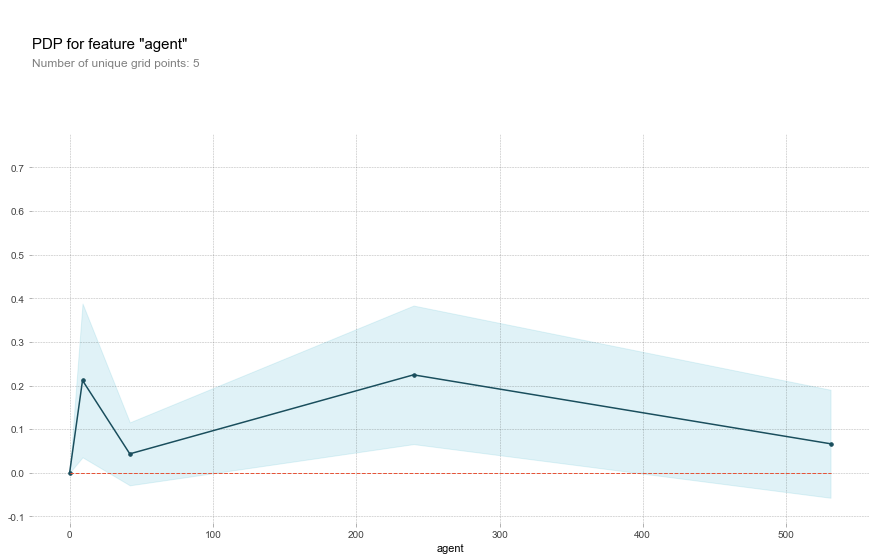

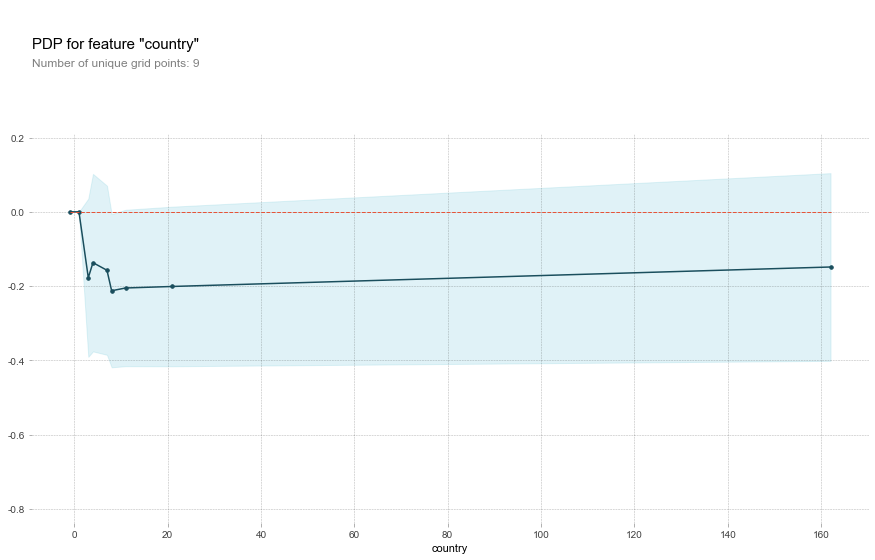

In [85]:
# pdp 
for i in top:
    isolated = pdp_isolate(
        model = XG_model,
        dataset = X_test_en,
        model_features = X_test_en.columns,
        feature = i,
        grid_type = 'percentile')
    pdp_plot(isolated, feature_name = i);

In [44]:
row = X_val_en.iloc[[1]]
explainer = shap.TreeExplainer(XG_model)
shap_values = explainer.shap_values(row)

In [45]:
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row
)

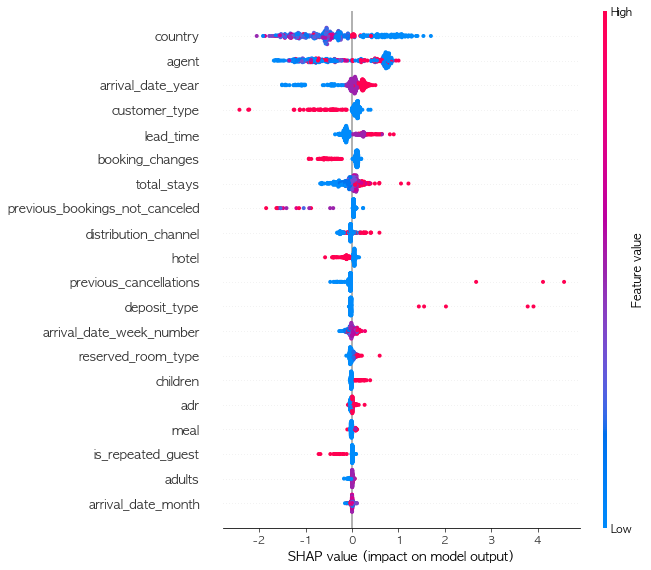

In [81]:
shap_values = explainer.shap_values(X_test_en.iloc[:400])
shap.summary_plot(shap_values, X_test_en.iloc[:400])

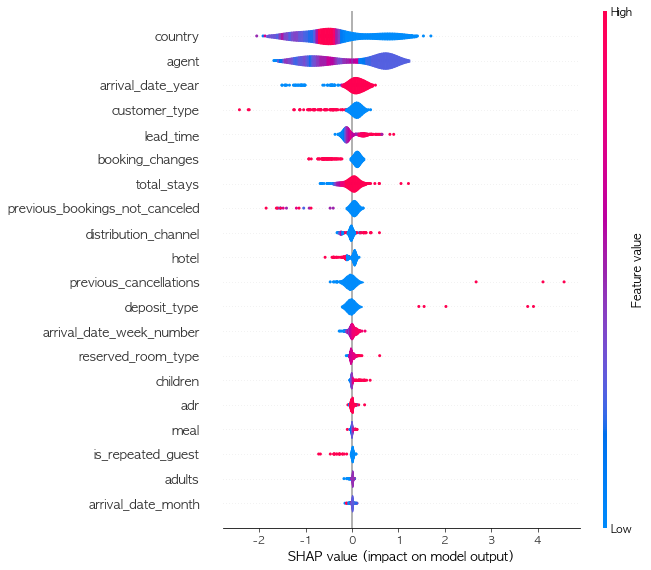

In [82]:
shap.summary_plot(shap_values, X_test_en.iloc[:400], plot_type = 'violin')

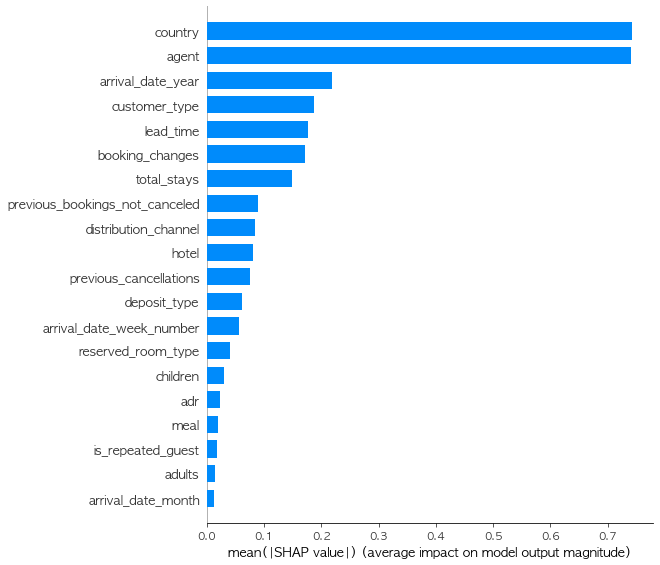

In [83]:
shap.summary_plot(shap_values, X_test_en.iloc[:200], plot_type = 'bar')